In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Dataloader

### MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(val_loader))

Number of training examples: 60000
Number of test examples: 625


### CelebA

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import CelebA

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

celeba_path = "./data/CelebA"

train_dataset = CelebA(root=celeba_path, split='train', transform=transform, download=True)
val_dataset = CelebA(root=celeba_path, split='test', transform=transform, download=True)

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(val_dataset))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 162770
Number of test examples: 19962


## Data viz

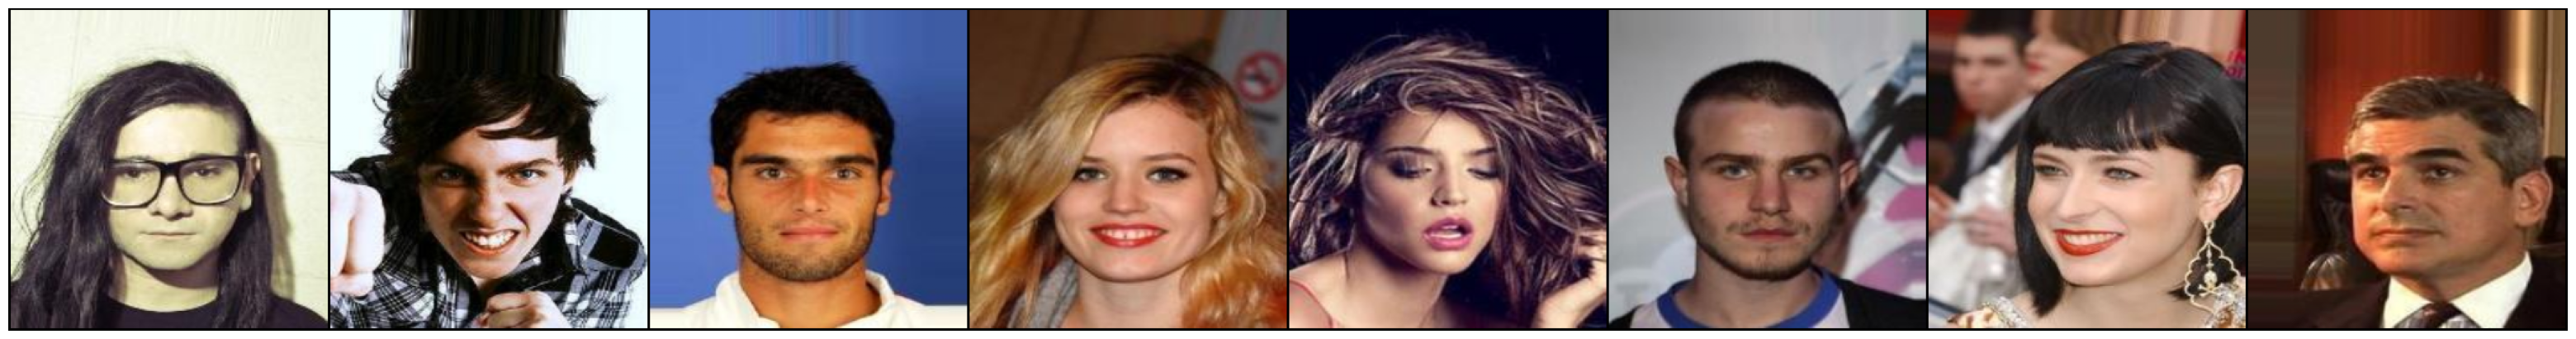

In [64]:
def viz(images_batch, save_path, plot_in_jupyter=True):
    grid = torchvision.utils.make_grid(images_batch, nrow=8, padding=2)
    grid = grid.numpy().transpose((1, 2, 0))

    if plot_in_jupyter:
        plt.figure(figsize=(40, 40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()
    else:
        plt.imsave(save_path, grid)
        plt.close()


data_iterator = next(iter(train_loader))
images_batch, labels_batch = data_iterator
viz(images_batch, "./batch_sample.png")

# Model

In [39]:
def elbo_loss(x, pred, z_mean, z_logvar):
    """
    loss = reconstruction_loss + KL
    KL: KL divergence between q(z|x) and p(z)
        KL[ q(z|x) || p(z) ] <==> KL[ N(u, std) || |N(0, 1) ]
        https://arxiv.org/pdf/1312.6114.pdf...
        "Solution of -DKL(q(z)||p(z)), Gaussian case" p. 10
        KL = [sum(1 + log(sigma^2) - mu^2 - sigma^2)] / 2
    Args:
        x (_type_): _description_
        pred (_type_): _description_
        z_mean (_type_): _description_
        z_std (_type_): _description_

    Returns:
        _type_: _description_
    """
    mse_loss = nn.MSELoss(reduction='sum')
    # print(f"elbo loss    x.shape >> {x.shape}")
    # print(f"elbo loss pred.shape >> {pred.shape}")
    reconstruction_loss = mse_loss(pred, x)
    kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return reconstruction_loss + kl_divergence

In [41]:
class Vae(nn.Module):
    def __init__(self, latent_dim=20, image_shape=(1, 28, 28)):
        super(Vae, self).__init__()
        self.image_shape = image_shape
        self.features = np.prod(self.image_shape)

        # encoder <==> q(z|x)
        self.encoder = nn.Sequential(
            nn.Linear(self.features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, latent_dim * 2)
        )

        # decoder <==> p(x|z)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, self.features),
            nn.Sigmoid()
        )


    def trick(self, mean, std):
        epsilon = torch.randn_like(std)
        return mean + std * epsilon
    

    def forward(self, x):
        x = x.view(-1, self.features)
        z = self.encoder(x)
        mu, logvar = torch.chunk(z, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        reparameterized = self.trick(mu, logvar)
        pred = self.decoder(reparameterized)
        pred = pred.reshape(-1, *self.image_shape)
        return pred, mu, std

## Optimization

In [67]:
from tqdm import tqdm

def train(model, train_loader, optimizer, device):
    train_loss = 0
    num_samples = len(train_loader.dataset)
    model.train()

    with tqdm(total=num_samples, desc="Training", unit="batch") as pbar:
        for idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            pred, mu, std = model(x)
            loss = elbo_loss(x, pred, mu, std)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            pbar.update(x.size(0))
            pbar.set_postfix(loss=train_loss / ((idx + 1) * train_loader.batch_size))

    return train_loss / num_samples


def val(model, val_loader, device):
    val_loss = 0
    num_samples = len(val_loader.dataset)
    model.eval()
    with torch.no_grad(), tqdm(total=num_samples, desc="Validation", unit="batch") as pbar:
        for x, _ in val_loader:
            x = x.to(device)
            pred, mu, std = model(x)
            val_loss += elbo_loss(pred, x, mu, std).item()
            pbar.update(x.size(0))

    return val_loss / len(val_loader)


def train_model(model, train_loader, val_loader, optimizer, device, epochs=10, early_stop_patience=5):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        _          = train(model, train_loader, optimizer, device)
        val_loss   = val(model, val_loader, device)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print(f'Early stopping at epoch {epoch}.')
                break
        

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Vae(latent_dim=10, image_shape=(3, 256, 256))
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    train_model(model, 
                train_loader, 
                val_loader, 
                optimizer, 
                device, 
                epochs=50,  
                early_stop_patience=5)


Training:   3%|▎         | 4440/162770 [06:09<3:39:28, 12.02batch/s, loss=1.23e+5][E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument



KeyboardInterrupt: 

### Reconstruction capacity

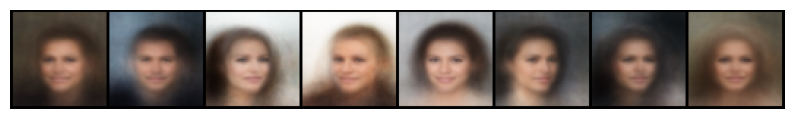

<Figure size 640x480 with 0 Axes>

In [34]:
x, y = next(iter(train_loader))
pred, _, _= model(x)
image_shape = (3, 64, 64)
pred = pred.reshape(-1, *image_shape).detach()
viz(pred)

### Sampler capacity

In [66]:
from torch.autograd import Variable
sample = Variable(torch.randn(10, 10))
print(f"sample shape >> {sample.shape}")
pred = model.decoder(sample)
pred = pred.reshape(-1, *image_shape).detach().numpy()
pred = torch.asarray(pred)
viz(pred)

sample shape >> torch.Size([10, 10])


TypeError: viz() missing 1 required positional argument: 'save_path'